# Multi-Arc Impedance Analysis# 

This notebook summarizes the attempt to apply the series connection of a series resistance $R_{s}$, an $RC/RQ$ arc, and a Randles circuit with **normal** diffusion to PbS-TBAI/ZnO impedance data that shows multiple arcs. At the moment, I believe that these separate arcs are due to the charge responses in these different layers: the $RC/RQ$ arc seems likely to emerge due to low frequency charge dynamics in the PbS, whereas the high frequency arc that becomes more prominent at high temperatures results from charge motion in the ZnO. In addition to the ample evidence from TAS that we have for drawing this distinction (which I should start summarizing...), this also matches our physical intuition--if the ZnO is indeed more heavily doped then not only should it contain an $RC/RQ$ arc due to recombination, but also a diffusion part that comes from  minority carrier diffusion to the electrode.

So, let's start the analysis. A catalog of potential models can be found in 'newData2_multiArc_Catalog.ipynb', so hopefully I won't have to spend too much time messing with different fits. Instead, let's try and run a temperature-dependent analysis, and see if we can extract lifetimes. I mostly care about the temperature dependence of $\tau$, but will obviously consider the temperature-depdnence of most of the fit parameters. 



In [2]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [15]:
import numpy as np
import lmfit as lmf
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import os
%matplotlib inline

os.chdir('C:\\Users\\Eric\\Desktop\\Lab_Work\\impedance\\PbS-TBAI\\ZnO_2\\dev2\\data')

# os.listdir()
tmax = 16
T = np.linspace(180,180+(10*tmax),tmax,endpoint=False)
devNum = 2
voltage1 = 400
voltage2 = 500

nPoints = 201
master400mv = np.zeros((tmax,nPoints,5))
master500mv = np.zeros((tmax,nPoints,5))

is400 = np.zeros((tmax,nPoints,4))
is500 = np.zeros((tmax,nPoints,4))

# the tmp data has the following format:
#      index 0 is frequency in rad/s
#      index 1 is capacitance, C
#      index 2 is susceptance, B
#      index 3 is dissipation, D
#      index 4 is conductance, G

# we create arrays to hold the impedance data (isv1/isv2) with the following format:
#      index 0 is Re(Z) in kOhm*cm^2
#      index 1 is Im(Z) in kOhm*cm^2
#      index 2 is |Z| in kOhm*cm^2
#      index 3 is phase angle \phi in degrees

for t in range(0,tmax):
    file1 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage1) + 'mV_All_Modified.txt'     
    tmp1 = np.genfromtxt(file1)
    master400mv[t,:,0] = tmp1[1:,0]
    master400mv[t,:,1] = savitzky_golay(tmp1[1:,1],51,5)
    master400mv[t,:,2] = savitzky_golay(tmp1[1:,2],51,5)
    master400mv[t,:,3] = savitzky_golay(tmp1[1:,3],51,5)
    master400mv[t,:,4] = savitzky_golay(tmp1[1:,4],51,5)

    is400[t,:,0] = ((master400mv[t,:,4]/((master400mv[t,:,4]**2) + (master400mv[t,:,2]**2)))*4e-2)/1e3
    is400[t,:,1] = ((-master400mv[t,:,2]/((master400mv[t,:,4]**2) + (master400mv[t,:,2]**2)))*4e-2)/1e3
    is400[t,:,2] = np.sqrt((is400[t,:,0]**2) + (is400[t,:,1]**2))
    is400[t,:,3] = -np.arctan(is400[t,:,1]/is400[t,:,0])*(180/np.pi)
                           
        
    file2 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage2) + 'mV_All_Modified.txt'     
    tmp2 = np.genfromtxt(file2)
    master500mv[t,:,0] = tmp2[1:,0]    
    master500mv[t,:,1] = savitzky_golay(tmp2[1:,1],51,5)
    master500mv[t,:,2] = savitzky_golay(tmp2[1:,2],51,5)
    master500mv[t,:,3] = savitzky_golay(tmp2[1:,3],51,5)
    master500mv[t,:,4] = savitzky_golay(tmp2[1:,4],51,5)

    is500[t,:,0] = ((master500mv[t,:,4]/((master500mv[t,:,4]**2) + (master500mv[t,:,2]**2)))*4e-2)/1e3
    is500[t,:,1] = ((-master500mv[t,:,2]/((master500mv[t,:,4]**2) + (master500mv[t,:,2]**2)))*4e-2)/1e3
    is500[t,:,2] = np.sqrt((is500[t,:,0]**2) + (is500[t,:,1]**2))
    is500[t,:,3] = -np.arctan(is500[t,:,1]/is500[t,:,0])*(180/np.pi)
    


# define some simple functions to make the analysis code a bit more concise
def Zr400(T):
    return is400[T,:,0]

def Zr500(T):
    return is500[T,:,0]

def Zi400(T):
    return is400[T,:,1]

def Zi500(T):
    return is500[T,:,1]

def Zmag400(T):
    return is400[T,:,2]

def Zmag500(T):
    return is500[T,:,2]

def phi400(T):
    return is400[T,:,3]

def phi500(T):
    return is500[T,:,3]

def w(T):
    return master400mv[t,:,0]

# input useful constants
kB = 8.617e-5

# make colormap
colSet = (cm.plasma(np.linspace(0,1,tmax)))

# indicate the figures directory
figDir = r'C:\Users\Eric\Desktop\Lab_Work\impedance\PbS-TBAI\ZnO_2\dev2\analysis\newModel'

# indicate offset, if any. tmin = 0 indicates no offset. otherwise, input another minumum temp to start analysis
tmin = 1


# Estimate $R_{s}$ by taking the highest frequency value of $Z_{r}$
RsEst400 = np.zeros(tmax)
RsEst500 = np.zeros(tmax)

for t in range (0,tmax): 
    RsEst400[t] = Zr400(t)[-1]
    RsEst500[t] = Zr500(t)[-1]
    
# define functions to output the magnitude and phase angle of the Rs-corrected plots.   
def Zmag400adj(T):
    return np.sqrt(((is400[t,:,0]-RsEst400[t])**2) + (is400[t,:,1]**2))

def Zmag500adj(T):
    return np.sqrt(((is500[t,:,0]-RsEst500[t])**2) + (is500[t,:,1]**2))

def phi400adj(T):
    return -np.arctan(is400[t,:,1]/(is400[t,:,0]-RsEst400[t]))*(180/np.pi)

def phi500adj(T):
    return -np.arctan(is500[t,:,1]/(is500[t,:,0]-RsEst500[t]))*(180/np.pi)

Take a quick look at the 400 mV data, to identify salient features. Note that we are also plotting  the $R_{s}$ correted data.

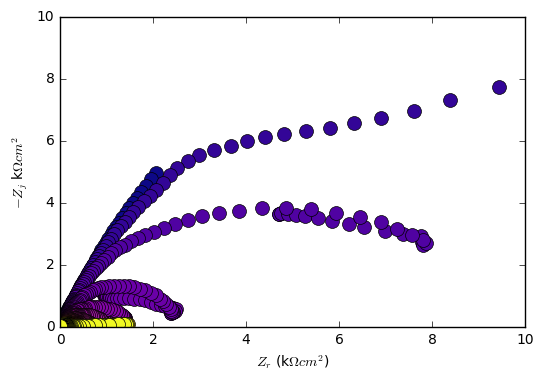

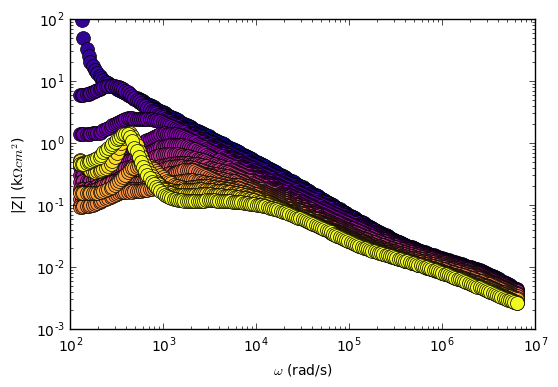

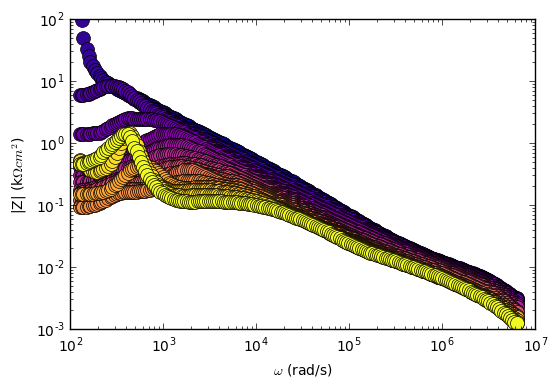

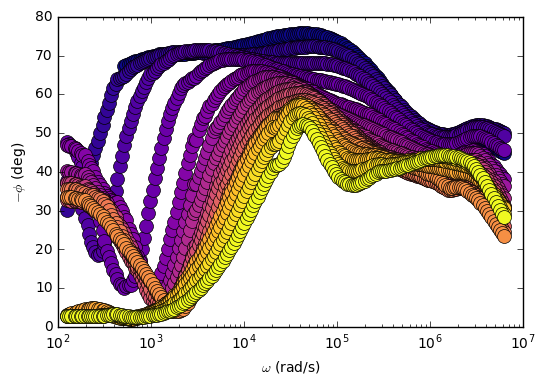

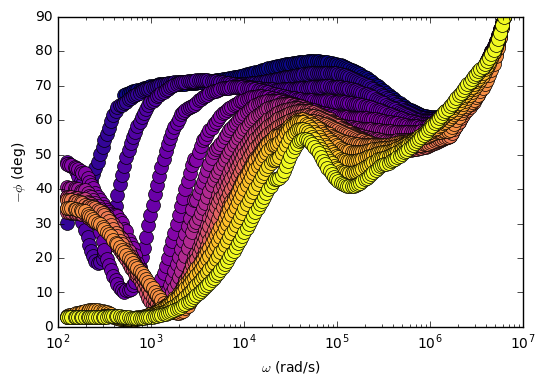

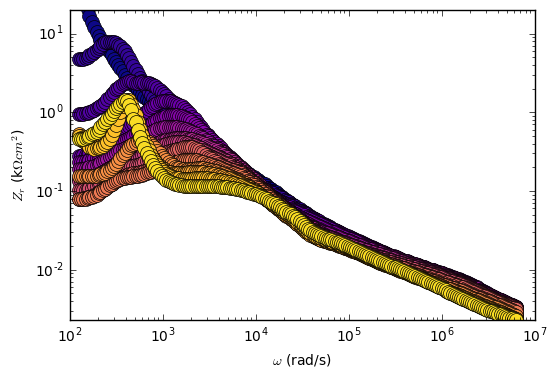

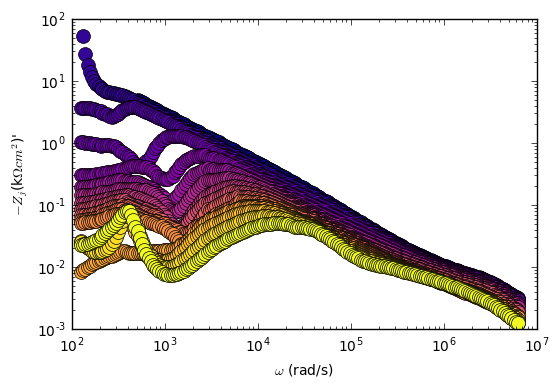

In [4]:
# Nyquist plots
fig,ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(Zr400(t),-Zi400(t),'o',c = c, markersize = 10)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{j}$ k$\Omega cm^{2}$")
ax.axis([0,10, 0,10])
# figName = '\\nyquist_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),Zmag400(t),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("|Z| vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# |Z|_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),Zmag400adj(t),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("$|Z|_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
# figName = '\\magZadj_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),phi400(t),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),phi400adj(t),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phaseAdj_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Re(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t),Zr400(t),'o', c = c, markersize = 10)
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Re(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([0,2e1]);
# figName = '\\reZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Im(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),abs(-Zi400(t)),'o', c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
# figName = '\\imZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

So, nothing too suprising here. It bodes well for our model! 

From the look of the adjusted phase angle plot, there are 2 inflection points: one at low frequency $\sim 1 \times  10^{3} < \omega <  \sim 4 \times 10^{4}$, and one at high frequencies $\sim 2 \times  10^{5} < \omega <  \sim 4 \times 10^{6}$. Seems to fit well with our equivalent circuit!

Continuing the analysis, let's check the offsets, etc. 

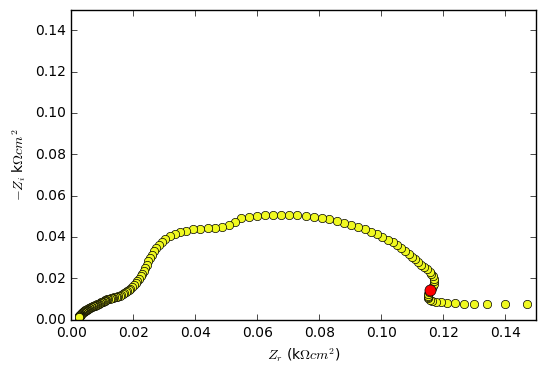

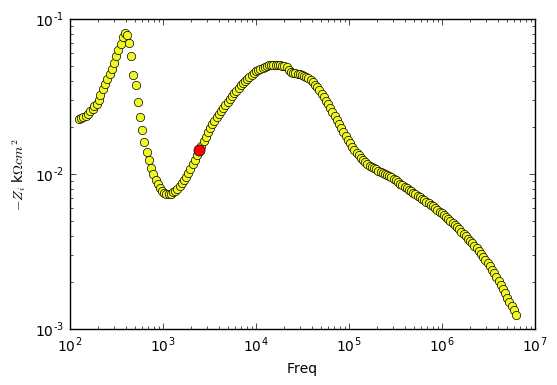

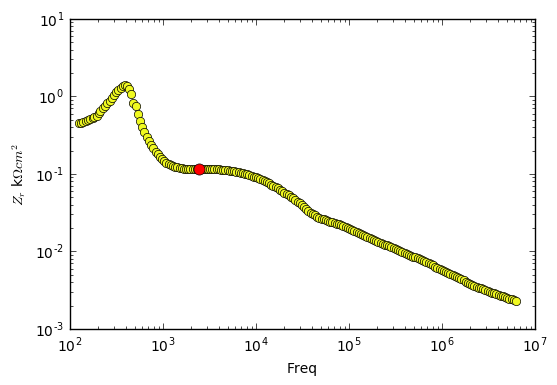

In [5]:
# clumsy way of ID-ing physically reasonable range of fit

bounds = np.zeros(tmax)

Tt = 15
offGuess = 55
# offSet = 2


fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt),-Zi400(Tt),'o', color = tuple(colSet[Tt]))
ax.plot(Zr400(Tt)[offGuess],-Zi400(Tt)[offGuess],'ro', markersize = 8)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,.15, 0,.15])

fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[offGuess],-Zi400(Tt)[offGuess],'ro', markersize = 8)
ax.set_xlabel("Freq")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.set_xscale("log") 
ax.set_yscale("log") 

fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),Zr400(Tt),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[offGuess],Zr400(Tt)[offGuess],'ro', markersize = 8)
ax.set_xlabel("Freq")
ax.set_ylabel("$Z_{r}$ k$\Omega cm^{2}$")
ax.set_xscale("log") 
ax.set_yscale("log") 

bounds[0] = 26
bounds[1] = 26
bounds[2] = 26
bounds[3] = 30
bounds[4] = 45
bounds[5] = 48
bounds[6] = 53
bounds[7] = 53
bounds[8] = 59
bounds[9] = 60
bounds[10] = 70
bounds[11] = 60
bounds[12] = 55
bounds[13] = 55
bounds[14] = 55
bounds[15] = 55

With our offsets set, let's go ahead and make the guesses. 

Note that we are using a quick and dirty method to gain estimates for the parameters. Note that we are starting with high temperature data, since the reactive arc features are most apparent at high $T$.

Also note that we are not provided a guess for $\alpha$. We can of course provide one by fitting the slope of one side of the peak, but let's see if we can get away with not doing that since it takes a while.

114
101
101
101
0.0167560096944 0.0614428372308
0.00137777482409 0.00123523738083


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


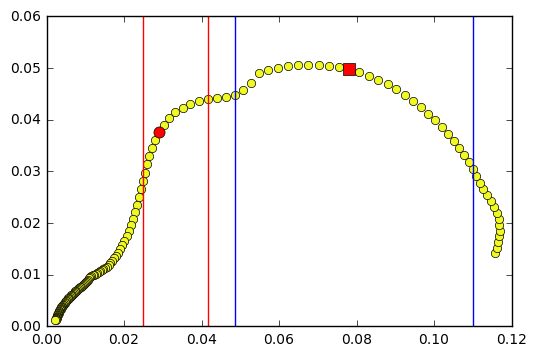

In [6]:
Tt = 15

# define a function that allows us to get the index of values read off the Nyquist plot so we know where to bound 
# the function in frequency
def ZrIdx(T,val):
    return max(np.where(Zr400(T) <= val))[0]


zbound1 = ZrIdx(Tt,0.025)
print(zbound1)

zbound2 = ZrIdx(Tt,0.043)
print(zbound2)

zbound3 = ZrIdx(Tt,0.05)
print(zbound2)

zbound4 = ZrIdx(Tt,0.11)
print(zbound2)

# guesses for charge transfer resistance based on arc radii. 1 is for high freq CPE, 2 is for low freq
guessRct1 = Zr400(Tt)[zbound2] - Zr400(Tt)[zbound1] 
guessRct2 = Zr400(Tt)[zbound4] - Zr400(Tt)[zbound3] 

print(guessRct1, guessRct2)

w0gIdx1 = ZrIdx(Tt,.03)
w0guess1 = w(Tt)[w0gIdx1]

w0gIdx2 = ZrIdx(Tt,.08)
w0guess2 = w(Tt)[w0gIdx2]

fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds[Tt]:],-Zi400(Tt)[bounds[Tt]:],'o', color = tuple(colSet[Tt]))

plt.axvline(Zr400(Tt)[zbound1],color = 'r')
plt.axvline(Zr400(Tt)[zbound2], color = 'r')

plt.axvline(Zr400(Tt)[zbound3])
plt.axvline(Zr400(Tt)[zbound4])

ax.plot(Zr400(Tt)[w0gIdx1],-Zi400(Tt)[w0gIdx1],'ro', markersize = 8)
ax.plot(Zr400(Tt)[w0gIdx2],-Zi400(Tt)[w0gIdx2],'rs', markersize = 8)

# guess for Q based on peak freq of each arc and Rct guesses above. 
guessQ1 = 1/(guessRct1*w0guess1)
guessQ2 = 1/(guessRct2*w0guess2)

print(guessQ1,guessQ2)


In [123]:
t1guess = (2*np.pi)/w(Tt)[ZrIdx(Tt,0.01)]
print(t1guess)

t2guess = (2*np.pi)/w(Tt)[ZrIdx(Tt,0.032)]
print(t2guess)

t3guess = (2*np.pi)/w(Tt)[ZrIdx(Tt,0.08)]
print(t3guess)

1.85663095653e-05
0.000180082838161
0.000476871706637


In [8]:
# define functions for the impedance of all circuit elements used in the analysis


# define a function for the impedance of a single RQ arc 
def arc(w,Rct,Q,alpha):
    return Rct/(1+((1j*w)**alpha)*Q*Rct)

# define a function for the impedace of a single RC arc
def voigt_el(w,Rct,tau):
    return Rct/(1+(1j*w*tau))

# define a function for the impedance of normal Warbug diffusion
def Zd(w,z0,td):
    return z0*(np.tanh(np.sqrt(1j*w*td))/np.sqrt(1j*w*td))

# define a function for the impedance of aCPE 
def cpe(w,Q,alpha):
    return 1/(((1j*w)**alpha)*Q)

# define a function for the impedance of a series resistor
def seriesR(w,c):
    return c

# define a function for the composite impedance of a normal Randles circuit
def randlesZ_finite(w,Rct,Q,alpha,z0,td):
    return (Rct +  Zd(w,z0,td) ) / (1 + ((1j*w)**alpha)*Q*(Rct + Zd(w,z0,td)))

#define a function for impedance due to anomalous diffusion as defined by Bisquert, et. al. just in case we need it 
def Za(w,z0,td,alpha):
    return z0*(np.tanh((1j*w*td)**(alpha/2))/((1j*w*td)**(alpha/2)))

#define a function for impedance of a complete Randles circuit with anomalous diffusion as defined by Bisquert, et. al.
def randlesZ_finite_anom(w,Rct,Q,alpha,z0,td):
    return (Rct +  Za(w,z0,td,alpha) ) / (1 + ((1j*w)**alpha)*Q*(Rct + Za(w,z0,td,alpha)))


from lmfit import Model
 


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:65: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[  171.43908442   170.69279566   169.87925273   169.32804102   168.84578136
   168.74969199   168.77008482   169.23088056   169.74647748   170.59210518
   171.74387457   172.66508784   173.5096865    174.48963145   175.27910884
   176.27080794   177.44986764   178.86680233   180.15813087   181.62130012
   183.32217111   185.24678094   187.50425591   189.66773355   192.03849326
   194.62103656   197.46552487   200.58126656   203.96863475   207.64235464
   211.62136898   215.91213834   220.57024385   225.57509122   230.94992414
   236.73823899   242.95127501   249.5837204    256.66310148   264.1987273
   272.21266379   282.7358994    292.98633185   302.56340913   311.76426263
   321.00258649   330.59949867   340.8293069    351.82981758   363.69529056
   376.46702131   390.15321882   404.73075454   420.23940509   436.63804311
   453.99442354   472.28114653   491.580857     511.85284035   533.18909957
   555.51406436   578.84012152   603.33815622   628.75066213   655.03388313
   682.143427

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:98: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:113: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


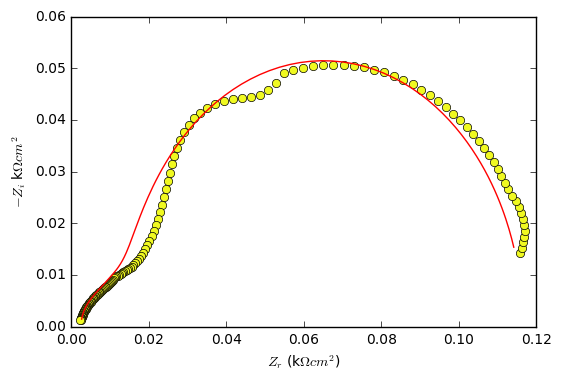

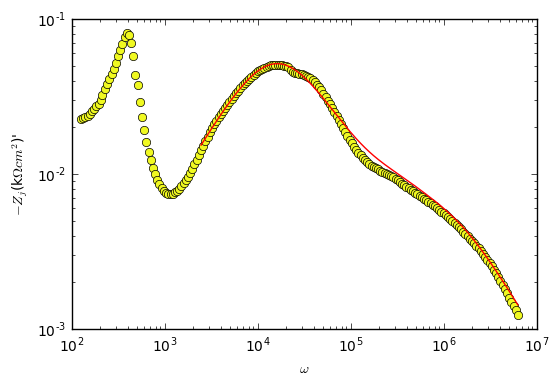

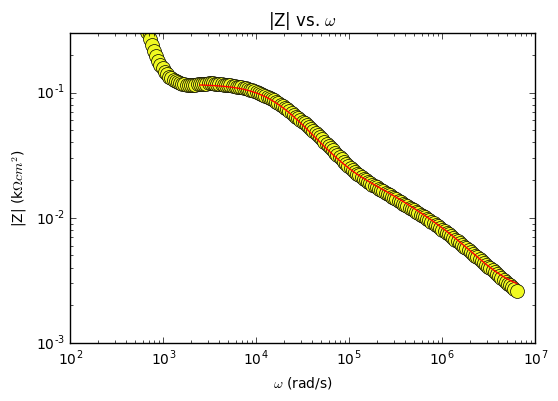

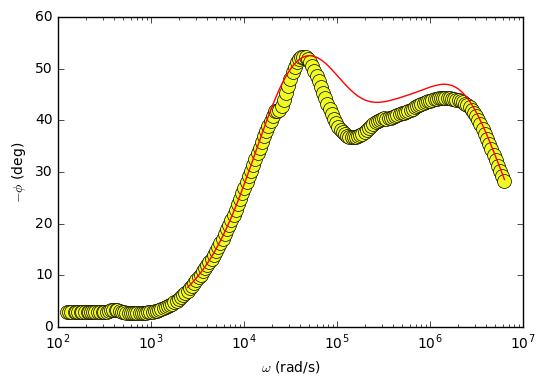

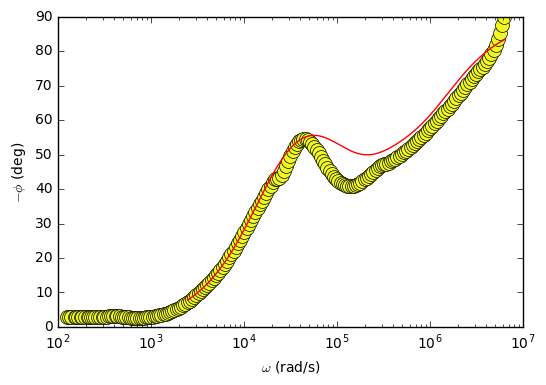

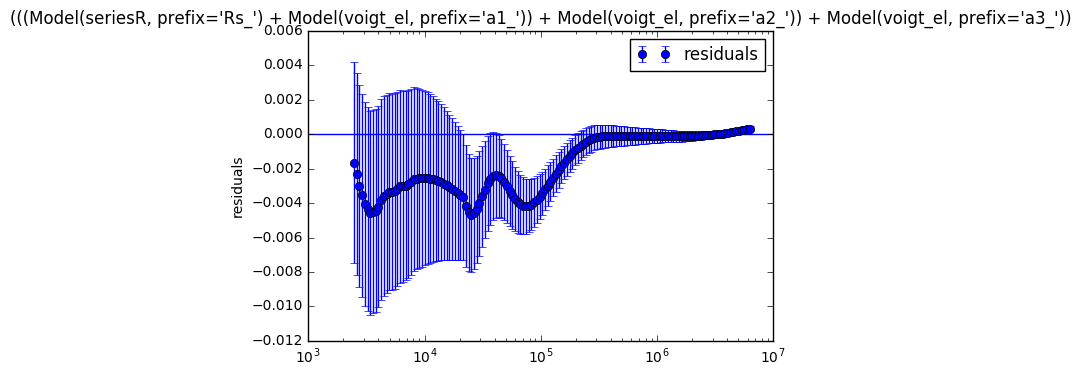

In [9]:
# define and run an aggregate voigt model. Note that we are initially running it for Tt, define above.

# define models for the circuit elements to be added in series
voigt1 = Model(voigt_el,prefix = 'a1_')
voigt2 = Model(voigt_el,prefix = 'a2_')
voigt3 = Model(voigt_el,prefix ='a3_')
# voigt4 = Model(voigt_el,prefix ='a4_')
# voigt5 = Model(voigt_el,prefix ='a5_')
# voigt6 = Model(voigt_el,prefix ='a6_')

Rs = Model(seriesR,prefix = 'Rs_')

# define the aggregate moel
vModel = Rs + voigt1 + voigt2 + voigt3 

# add parameters with guesses
params = lmf.Parameters()  

params.add('Rs_c',value =  .003, min = 0, max = 5)

params.add('a1_Rct',value = 0.01, min = 0, max = 5)
params.add('a1_tau',value = t1guess, min = 0, max = 1e-4)

params.add('a2_Rct',value = guessRct1, min = 0, max = 5)
params.add('a2_tau',value = t2guess, min = 0, max = 1e-3)

params.add('a3_Rct',value = guessRct2, min = 0, max = 5)
params.add('a3_tau',value = t3guess, min = 0, max = 1e-3)

# params.add('a4_Rct',value = guessRct2, min = 0, max = 5)
# params.add('a4_tau',value = t3guess, min = 0, max = 1e-3)


# make the data complex
data = Zr400(Tt)[bounds[Tt]:]+1j*Zi400(Tt)[bounds[Tt]:]
weights = 1/(.05*Zmag400(Tt)[bounds[Tt]:])

# for idx in range(len(weights)):
#     if idx >= w1 and idx <=w2:
#         weights[idx] = 1e6
print(weights)


#try the fit
fit_result = vModel.fit(data, w = w(Tt)[bounds[Tt]:],params = params, weights = weights)
print(fit_result.fit_report())

# store the Rs fit value to check the phase angle plot
RsFit = fit_result.params['Rs_c'].value

# fig,ax = fit_result.plot()
# ax.set_xscale('log')

# make arrays that store the real and imaginary parts, magnitude, and phase (both raw and adjusted)
fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)
imFit = np.imag(fit_result.best_fit)
phiFit = -np.arctan(imFit/reFit)*(180/np.pi)
phiFitAdj = -np.arctan(imFit/(reFit - RsFit))*(180/np.pi)

-np.arctan(is400[t,:,1]/is400[t,:,0])*(180/np.pi)

# Nyquist with fit
fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds[Tt]:],-Zi400(Tt)[bounds[Tt]:],'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
# ax.set_aspect('equal')

# Z_i with fit
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds[Tt]:],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),Zmag400(Tt),'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds[Tt]:],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),phi400(Tt),'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds[Tt]:],phiFit, color = 'r')
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),phi400adj(Tt),'o',c = c, markersize = 10)
ax.plot(w(Tt)[bounds[Tt]:],phiFitAdj, color = 'r')
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phaseAdj_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

fig,ax = plt.subplots(1,1)
ax.set_xscale('log')
fit_result.plot_residuals(ax=ax)


In [10]:
print(range(len(weights)))

range(0, 146)


19239.113
102937.425
93 124


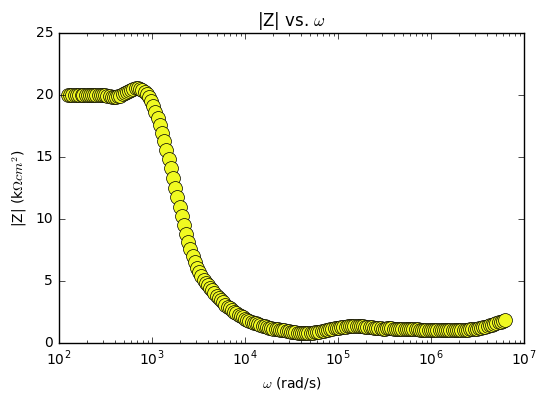

In [11]:
# plot dissipation to check where the data is 'good' or 'bad'

fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),master400mv[Tt,:,3],'o',c = tuple(colSet[Tt]), markersize = 10) 

ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
# ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)


print(w(Tt)[ZrIdx(Tt,0.06)])
w1 = ZrIdx(Tt,0.06)

print(w(Tt)[ZrIdx(Tt,0.02)])
w2 = ZrIdx(Tt,0.02)

print(w1,w2)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[   85.71954221    85.34639783    84.93962637    84.66402051    84.42289068
    84.37484599    84.38504241    84.61544028    84.87323874    85.29605259
    85.87193728    86.33254392    86.75484325    87.24481573    87.63955442
    88.13540397    88.72493382    89.43340116    90.07906544    90.81065006
    91.66108555    92.62339047    93.75212795    94.83386677    96.01924663
    97.31051828    98.73276244   100.29063328   101.98431738   103.82117732
   105.81068449   107.95606917   110.28512192   112.78754561   115.47496207
   118.3691195    121.4756375    124.7918602    128.33155074   132.09936365
   136.10633189   141.3679497    146.49316593   151.28170456   155.88213131
   160.50129324   165.29974933   170.41465345   175.91490879   181.84764528
   188.23351065   195.07660941   202.36537727   210.11970254   218.31902156
   226.99721177   236.14057326   245.7904285    255.92642017   266.59454978
   277.75703218   289.42006076   301.66907811   314.37533106   327.51694156
   341.07171

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:68: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:106: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


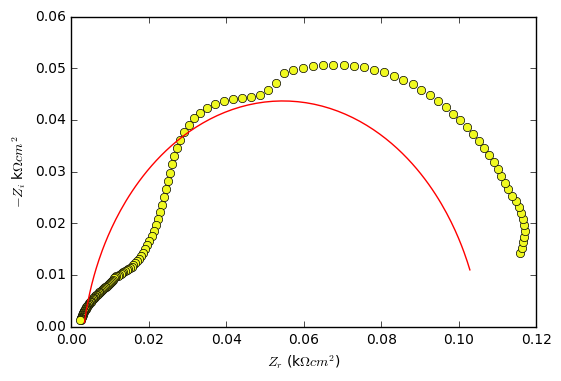

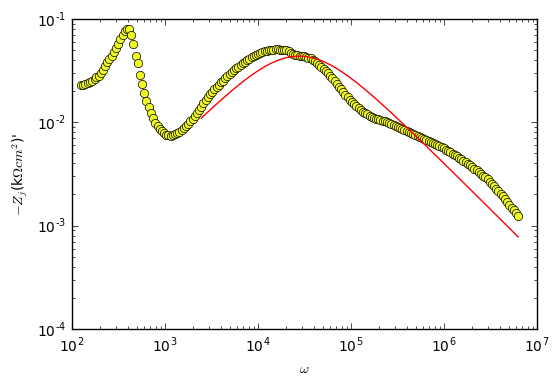

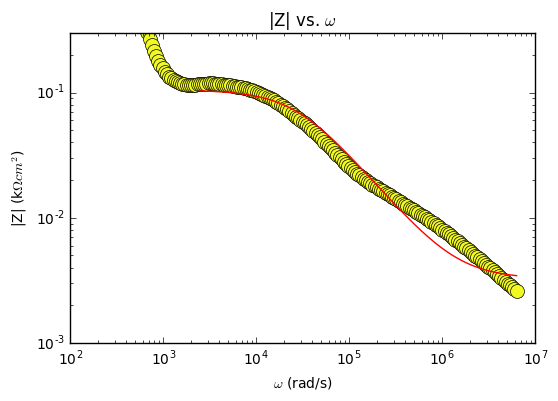

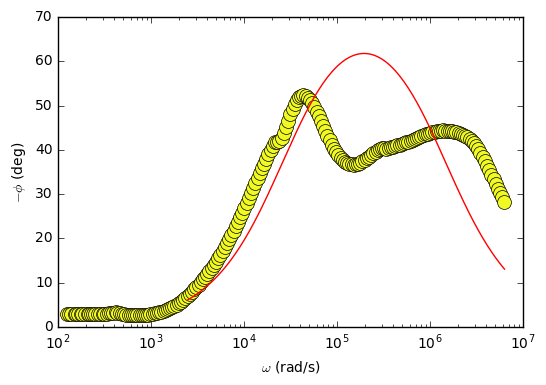

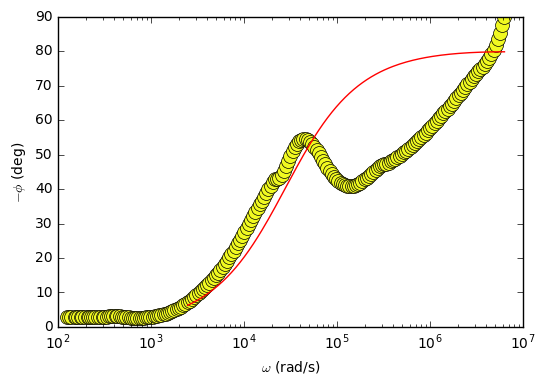

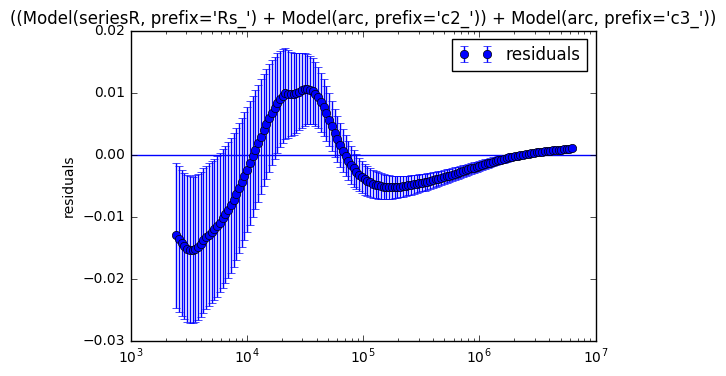

In [12]:
# try a series CPE model with the weighted fits. CPE 1 is the highest freq, CPE 3 is the lowest freq

# define and run an aggregate voigt model. Note that we are initially running it for Tt, define above.

# define models for the circuit elements to be added in series
cpe1 = Model(arc,prefix = 'c1_')
cpe2 = Model(arc,prefix = 'c2_')
cpe3 = Model(arc,prefix = 'c3_')
# cpe4 = Model(arc,prefix = 'c2_')

Rs = Model(seriesR,prefix = 'Rs_')

# define the aggregate moel
cpeModel = Rs + cpe2 + cpe3

# add parameters with guesses
params = lmf.Parameters()  

params.add('Rs_c',value =  .003, min = 0, max = 5)

# params.add('c1_Rct',value = 0.01, min = 0, max = 5)
# params.add('c1_Q',value = 4e-5, min = 0, max = 1e-4)
# params.add('c1_alpha',value = 0.95 , min = 0, max = 1)

params.add('c2_Rct',value = guessRct1, min = 0, max = 5)
params.add('c2_Q',value = guessQ1, min = 0, max = 1e-3)
params.add('c2_alpha',value = 0.6, min = 0, max = 1)

params.add('c3_Rct',value = guessRct2, min = 0, max = 5)
params.add('c3_Q',value = 4e-4, min = 0, max = 1e-3)
params.add('c3_alpha',value = 0.6, min = 0, max = 1)

# make the data complex
data = Zr400(Tt)[bounds[Tt]:]+1j*Zi400(Tt)[bounds[Tt]:]
weights = 1/(.1*Zmag400(Tt)[bounds[Tt]:])
print(weights)

#try the fit
fit_result = cpeModel.fit(data, w = w(Tt)[bounds[Tt]:],params = params, weights = weights)

print(fit_result.fit_report())

# fig,ax = fit_result.plot()
# ax.set_xscale('log')

# store the Rs fit value to check the phase angle plot
RsFit = fit_result.params['Rs_c'].value

# make arrays that store the real and imaginary parts for the fit and the magnitude 
fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)
imFit = np.imag(fit_result.best_fit)
phiFit = -np.arctan(imFit/reFit)*(180/np.pi)
phiFitAdj = -np.arctan(imFit/(reFit - RsFit))*(180/np.pi)

# Nyquist with fit
fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds[Tt]:],-Zi400(Tt)[bounds[Tt]:],'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
# ax.set_aspect('equal')

# Z_i with fit
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds[Tt]:],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),Zmag400(Tt),'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds[Tt]:],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),phi400(Tt),'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds[Tt]:],phiFit, color = 'r')
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),phi400adj(Tt),'o',c = c, markersize = 10)
ax.plot(w(Tt)[bounds[Tt]:],phiFitAdj, color = 'r')
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phaseAdj_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)


fig,ax = plt.subplots(1,1)
ax.set_xscale('log')
fit_result.plot_residuals(ax=ax)



As a next step, let's consider the voltage-dependence of the line shapes. From Firooz (and the Orazem textbook), we need to consider linearity in our system. For JV curves that are non-linear, *small* perturbations should be used. For linear JV relationships, large amplitudes can be used. 

Basically, it matters what voltage we are applying. Perhaps 400 mV is simply too low--we are in some non-linear regime, and we get goofy data. We need to do a more systematic test of this, but let's first frun the 500 mV data to see if it looks any better, *and* look at the JV curve of the device. 

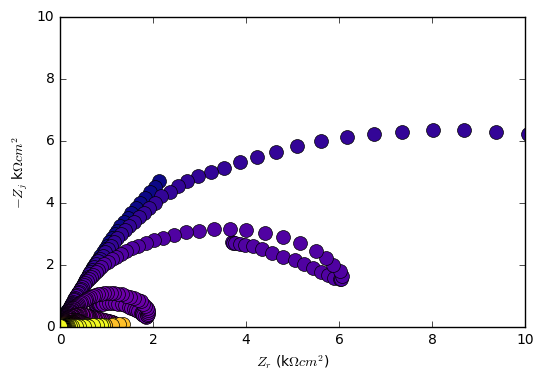

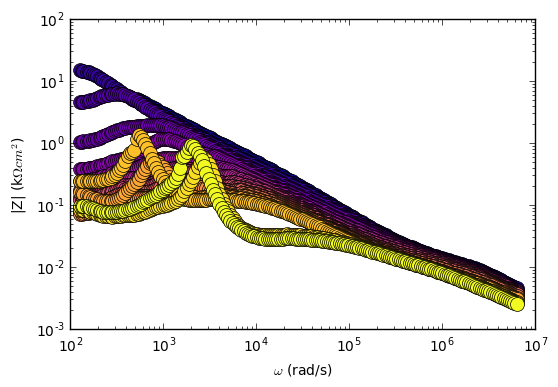

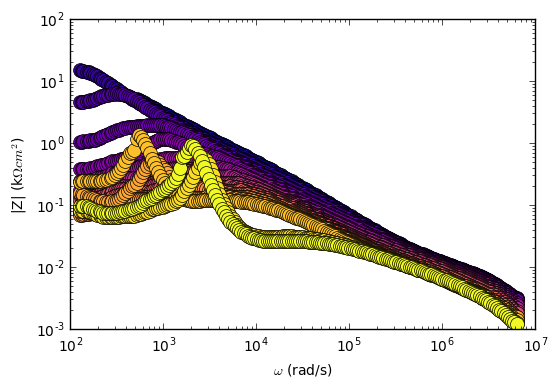

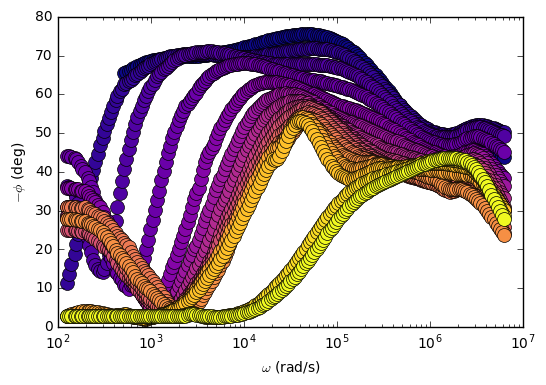

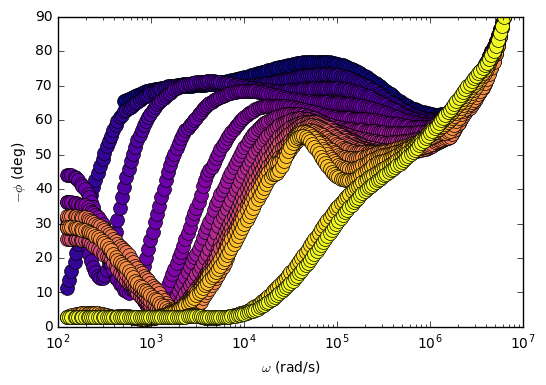

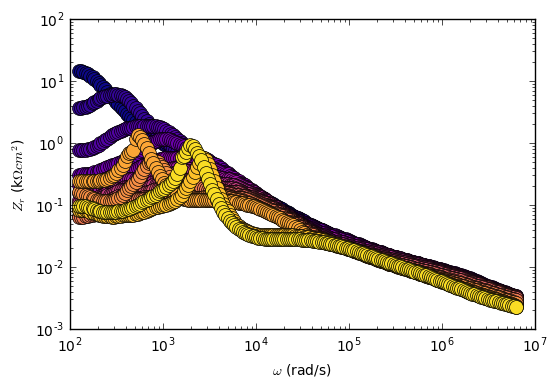

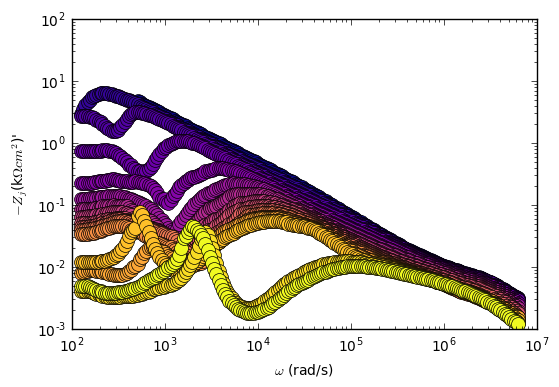

In [18]:
# Nyquist plots
fig,ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(Zr500(t),-Zi500(t),'o',c = c, markersize = 10)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{j}$ k$\Omega cm^{2}$")
ax.axis([0,10, 0,10])
# figName = '\\nyquist_500mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),Zmag500(t),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("|Z| vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_500mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# |Z|_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),Zmag500adj(t),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("$|Z|_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
# figName = '\\magZadj_500mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),phi500(t),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_500mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),phi500adj(t),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phaseAdj_500mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Re(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t),Zr500(t),'o', c = c, markersize = 10)
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Re(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([0,2e1]);
# figName = '\\reZ_500mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Im(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),abs(-Zi500(t)),'o', c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
# figName = '\\imZ_500mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

[0, 0.2, 0, 0.2]

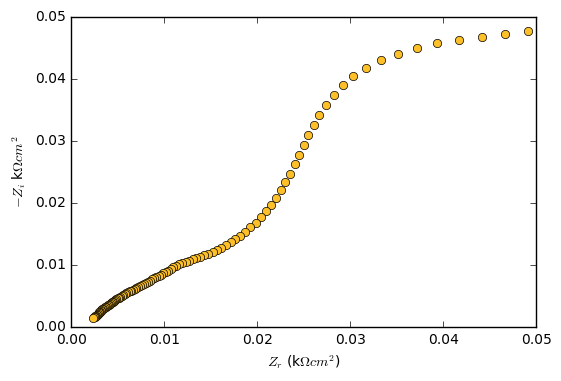

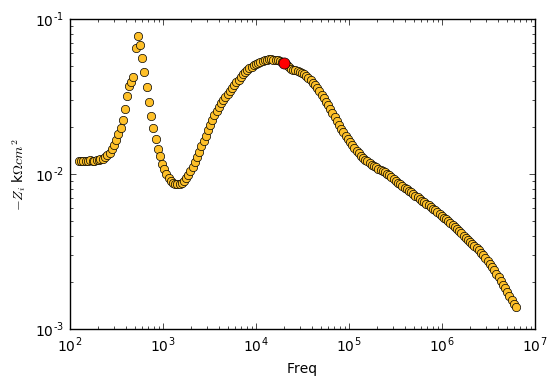

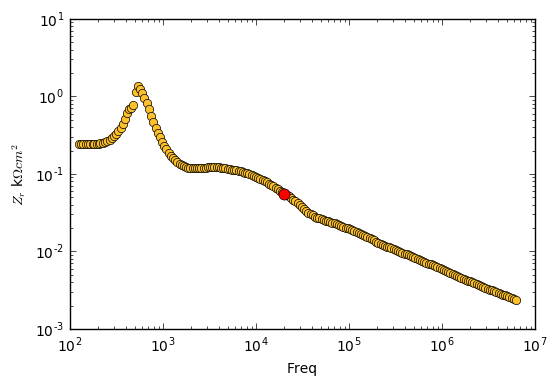

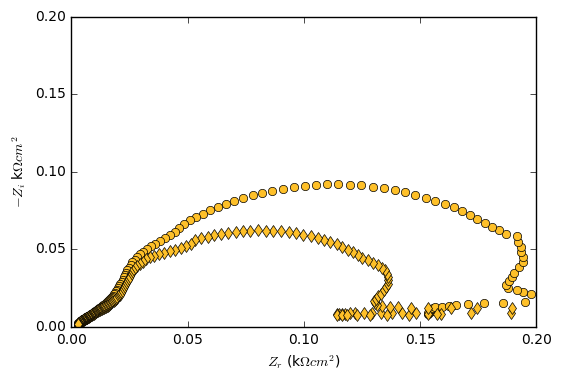

In [88]:
# Look at highest temperature Nyquist plots

bounds2 = np.zeros(tmax)

Tt = 13
offGuess = 94
# offSet = 2


fig,ax = plt.subplots(1,1)
ax.plot(Zr500(Tt),-Zi500(Tt),'o', color = tuple(colSet[Tt]))
ax.plot(Zr500(Tt)[offGuess],-Zi500(Tt)[offGuess],'ro', markersize = 8)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,0.05, 0,0.05])

fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi500(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[offGuess],-Zi500(Tt)[offGuess],'ro', markersize = 8)
ax.set_xlabel("Freq")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.set_xscale("log") 
ax.set_yscale("log") 

fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),Zr500(Tt),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[offGuess],Zr500(Tt)[offGuess],'ro', markersize = 8)
ax.set_xlabel("Freq")
ax.set_ylabel("$Z_{r}$ k$\Omega cm^{2}$")
ax.set_xscale("log") 
ax.set_yscale("log") 

bounds2[0] = 26
bounds2[1] = 0
bounds2[2] = 16
bounds2[3] = 30
bounds2[4] = 50
bounds2[5] = 58
bounds2[6] = 70
bounds2[7] = 70
bounds2[8] = 72
bounds2[9] = 75
bounds2[10] = 79
bounds2[11] = 79
bounds2[12] = 69
bounds2[13] = 69
bounds2[14] = 94
bounds2[15] = 94

rt = np.where(T == 300)[0]

fig,ax = plt.subplots(1,1)
ax.plot(Zr400(rt),-Zi400(rt),'o', color = tuple(colSet[Tt]))
ax.plot(Zr500(rt),-Zi500(rt),'d', color = tuple(colSet[Tt]))
# ax.plot(Zr400(rt)[offGuess],-Zi400(rt)[offGuess],'ro', markersize = 8)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,0.2, 0,0.2])

These look better, at higher temperatures, but note that they still have the same weird shoulder at the same frequency range. We need to do more experiments to understand the origin of this: would running at lower voltages fixes this? Higher voltages? What about a range of AC amplitudes? Maybe we can run at large ampltiudes depending on how the JV curve looks. So, let's look at them curvez.



In [114]:
# import JV data

nPointsJV = 48
masterIV = np.zeros((tmax,nPointsJV,2))
jv = np.zeros((tmax,nPointsJV,2))

# the tmp data has the following format:
#      index 0 is voltage V
#      index 1 is current, I
#      index 2 is 'gate current', IG (this is noise)


# we create arrays to hold the jv data with the following format:
#      index 0 is voltage 
#      index 1 is current density J in mA/cm^2


for t in range(0,tmax):
    file3 = 'dev' + str(devNum) + '_IVDark_' + np.array2string(T[t].astype(int)) +'K.txt'
    tmp3 = np.genfromtxt(file3,delimiter=",")
    masterIV[t,:,0] = tmp3[1:,0]
    masterIV[t,:,1] = tmp3[1:,1]

    jv[t,:,0] = masterIV[t,:,0]
    jv[t,:,1] = (masterIV[t,:,1]*1e3)/4e-2

                                

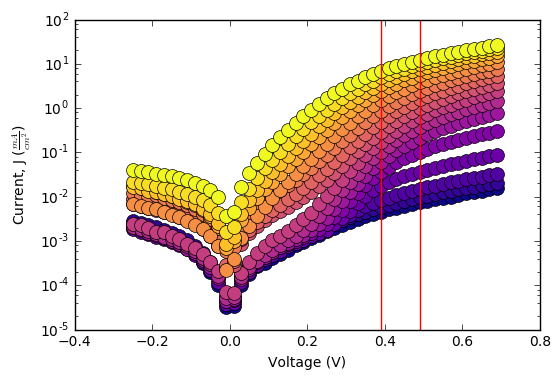

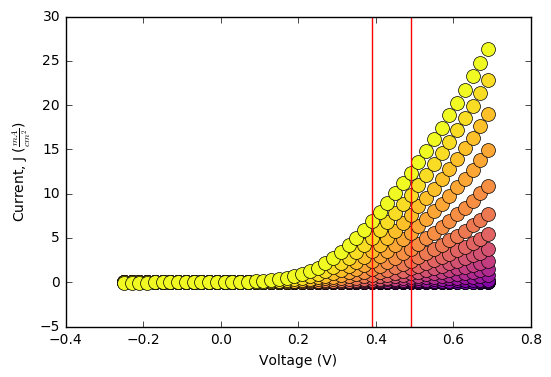

In [122]:
# plot the JV data

volt1 = 0.39
volt2 = 0.49

indVolt1 = np.where(jv[0,:,0]==volt1)
indVolt2 = np.where(jv[0,:,0] == volt2)


fig,ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(jv[t,:,0],abs(jv[t,:,1]),'o',c = c, markersize = 10)
#     ax.plot(jv[t,indVolt1,0],abs(jv[t,indVolt1,1]),'rd',markersize = 15)
#     ax.plot(jv[t,indVolt2,0],abs(jv[t,indVolt2,1]),'rd',markersize = 15)
    
plt.axvline(jv[t,indVolt1,0],color = 'r')
plt.axvline(jv[t,indVolt2,0],color = 'r')
ax.set_xlabel("Voltage (V)")
ax.set_ylabel("Current, J ($\\frac{mA}{cm^{2}}$)")
ax.set_yscale("log") 
# ax.set_title("I vs. V")
# plt.savefig('IV.png')


fig,ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(jv[t,:,0],jv[t,:,1],'o',c = c, markersize = 10)
#     ax.plot(jv[t,indVolt1,0],abs(jv[t,indVolt1,1]),'rd',markersize = 15)
#     ax.plot(jv[t,indVolt2,0],abs(jv[t,indVolt2,1]),'rd',markersize = 15)
    
plt.axvline(jv[t,indVolt1,0],color = 'r')
plt.axvline(jv[t,indVolt2,0],color = 'r')
ax.set_xlabel("Voltage (V)")
ax.set_ylabel("Current, J ($\\frac{mA}{cm^{2}}$)")
# ax.set_yscale("log") 
# ax.set_title("I vs. V")
# plt.savefig('IV.png')

In [113]:
# print(os.getcwd())

# print(tmp3[1:,0].shape)
# print(tmp3[1:,1])

print(masterIV[1,:,0])

[-0.25 -0.23 -0.21 -0.19 -0.17 -0.15 -0.13 -0.11 -0.09 -0.07 -0.05 -0.03
 -0.01  0.01  0.03  0.05  0.07  0.09  0.11  0.13  0.15  0.17  0.19  0.21
  0.23  0.25  0.27  0.29  0.31  0.33  0.35  0.37  0.39  0.41  0.43  0.45
  0.47  0.49  0.51  0.53  0.55  0.57  0.59  0.61  0.63  0.65  0.67  0.69]


We should probably also monitor the 0 bias capacitance, as recomended by Bisquert. We recognize what this looks like for the old cells (note: it looks *exactly* like what he has in his paper [doi: 10.1021/acs.jpclett5b00480](https://pubs.acs.org/doi/pdf/10.1021/acs.jpclett.5b00480) and this one [doi: 10.1021/jp5062144](https://pubs.acs.org/doi/abs/10.1021/jp5062144)). If the capacitance looks similar, it's a good sign that we should go ahead and use some variant of his equivalent circuit with the attendent interpretation.

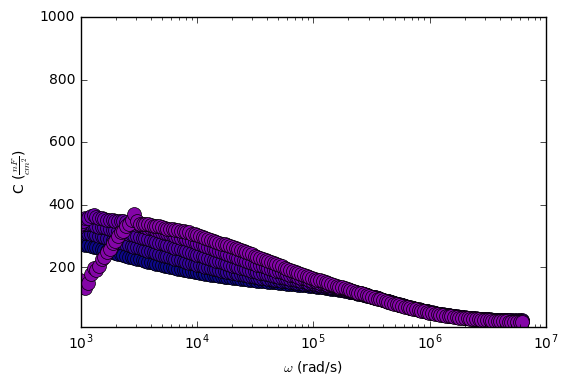

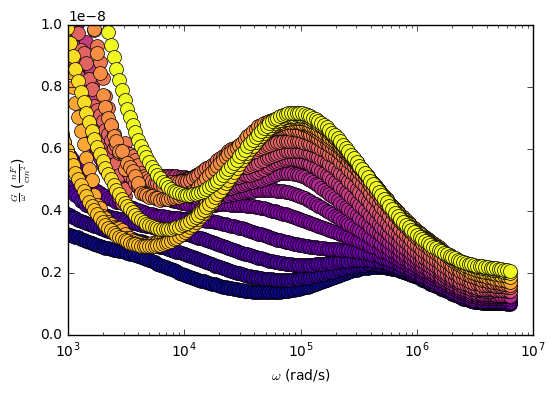

In [149]:
master0mv = np.zeros((tmax,nPoints,5))

is0 = np.zeros((tmax,nPoints,4))

voltage3 = 0

# the tmp data has the following format:
#      index 0 is frequency in rad/s
#      index 1 is capacitance, C
#      index 2 is susceptance, B
#      index 3 is dissipation, D
#      index 4 is conductance, G

# we create arrays to hold the impedance data (isv1/isv2) with the following format:
#      index 0 is Re(Z) in kOhm*cm^2
#      index 1 is Im(Z) in kOhm*cm^2
#      index 2 is |Z| in kOhm*cm^2
#      index 3 is phase angle \phi in degrees

for t in range(0,tmax):
    file4 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage3) + 'mV_All_Modified.txt'     
    tmp4 = np.genfromtxt(file4)
    master0mv[t,:,0] = tmp1[1:,0]
    master0mv[t,:,1] = savitzky_golay(tmp4[1:,1],51,5)
    master0mv[t,:,2] = savitzky_golay(tmp4[1:,2],51,5)
    master0mv[t,:,3] = savitzky_golay(tmp4[1:,3],51,5)
    master0mv[t,:,4] = savitzky_golay(tmp4[1:,4],51,5)

    is0[t,:,0] = ((master0mv[t,:,4]/((master0mv[t,:,4]**2) + (master0mv[t,:,2]**2)))*4e-2)/1e3
    is0[t,:,1] = ((-master0mv[t,:,2]/((master0mv[t,:,4]**2) + (master0mv[t,:,2]**2)))*4e-2)/1e3
    is0[t,:,2] = np.sqrt((is0[t,:,0]**2) + (is0[t,:,1]**2))
    is0[t,:,3] = -np.arctan(is0[t,:,1]/is0[t,:,0])*(180/np.pi)
                           

# define a function to return the capacitance/unit area in nF/cm^{-2]}        
def capAS(T):
    return (master0mv[T,:,1]*1e9)/4e-2

def gOmega(T):
    return (master0mv[T,:,4]/master0mv[T,:,0])

# cap vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,5),colSet):
    ax.plot(w(t),capAS(t),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("C ($\\frac{nF}{cm^{2}}$)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("|Z| vs. $\omega$")
ax.set_xlim([1e3,1e7]);
ax.set_ylim([1e1,1e3]);
# figName = '\\magZ_500mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

   
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),gOmega(t),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$\\frac{G}{\omega}$ ($\\frac{nF}{cm^{2}}$)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("|Z| vs. $\omega$")
ax.set_xlim([1e3,1e7]);
ax.set_ylim([0,1e-8]);
# figName = '\\magZ_500mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)



Hm. This looks odd. It's not quite what I expected. There is a lot of noise for some reason in the mid temperatures in the capacitance measurement, though the the conductance vurves look more or less like I expect. 

Dear god I hope the instrument is fine. Shit. 

We should go back and look at the impedance for the old data set. 